# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a **reusable, handoff-ready API or dashboard** and finalize your project for reproducibility and clarity.

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## 1. Create mock, very basic analysis

In [1]:
# Setup & Import dataset
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/engineered_features.csv", parse_dates=['date'])
df.head()

,date,spx_close,vix,dgs10,fedfunds,cpi,unrate,spx_ret,rv_21d_pct,vrp_ratio,rate_shock_5d_bps
0,2020-10-23,0.070698,0.387695,0.85,0.09,260.319,6.9,0.053491,721.180880,-0.999462,9.0
1,2020-10-26,0.050764,0.509019,0.81,0.09,260.319,6.9,-0.331233,395.760560,-0.998714,3.0
2,2020-10-27,0.047580,0.531011,0.79,0.09,260.319,6.9,-0.064779,337.028035,-0.998424,-2.0
3,2020-10-28,0.010555,0.702249,0.79,0.09,260.319,6.9,-1.505799,624.620781,-0.998876,-4.0
4,2020-10-29,0.022648,0.635780,0.85,0.09,260.319,6.9,0.763468,678.915848,-0.999064,-2.0


In [2]:
# Basic analysis
# print(df.describe())
# print("\n")
# print(df.corr()["spx_ret"].sort_values(ascending=False))
# print("\n")
print("Basic analysis complete.")

Basic analysis complete.


## 2. Notebook Cleanup
Remove exploratory cells and document your code.

In [3]:
# Example placeholder for cleaned analysis
print("Notebook cleaned and ready for handoff.")

Notebook cleaned and ready for handoff.


## 3. Move reusable functions to /src/
Create src/utils.py and store functions there.

In [4]:
import sys
import os

# Add parent folder to sys.path
sys.path.append(os.path.abspath(".."))

from src.utils import *

# def calculate_metrics(df):
#     return df.describe()
print("src/utils.py are successfully implemented.")

src/utils.py are successfully implemented.


## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:
```
project/
  data/
  notebooks/
  src/
  reports/
  model/
  README.md
```
For API/Dashboard: minimal example:
```
project/
    app.py
    model.pkl
    requirements.txt
    README.md
```

## 5. Pickle / Save Final Model

In [5]:
# Implement model 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

X = df[["spx_close","vix","dgs10","fedfunds","cpi",
        "unrate","rv_21d_pct","vrp_ratio","rate_shock_5d_bps"]]
y = df["spx_ret"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))

Coefficients: [ 1.25182438e-01  2.41220117e-02  3.72879508e-03  5.22606759e-03
 -2.22134545e-03 -1.57497742e-02  2.07780203e-04 -5.75439987e+00
 -4.12313998e-04]
Intercept: -5.108476512187234
R²: -0.0920205256041049
RMSE: 0.01050586964447944


In [6]:
import pickle

os.makedirs("../model", exist_ok=True)  # ensure folder exists

with open('../model/model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved to model/model.pkl")

# Test loading the model
with open('../model/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
print("Model successfully reloaded.")

example_features = [[0.1, 0.2, 0.3, 0.5, 260, 7.0, 500, -0.99, 0.0]]
print("Example prediction:", loaded_model.predict(example_features))

Model saved to model/model.pkl
Model successfully reloaded.
Example prediction: [0.02554554]


/opt/miniconda3/envs/bootcamp_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## 6. Flask API Starter

### Implement Flask endpoints for /predict and /plot

In [7]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io
import base64

MODEL_PATH = "../model/model.pkl"

if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file not found at {MODEL_PATH}. Train the model first.")

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)
    
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    """
    Expects JSON: {"features": [spx_close, vix, dgs10, fedfunds, cpi, unrate, rv_21d_pct, vrp_ratio, rate_shock_5d_bps]}
    Returns model prediction for SPX returns.
    """
    data = request.get_json()
    features = data.get('features', None)
    if features is None:
        return jsonify({'error': 'No features provided'}), 400

    if len(features) != 9:
        return jsonify({"error": "Expected 9 features"}), 400

    features_array = np.array(features).reshape(1, -1)
    pred = model.predict(features_array)[0]
    
    return jsonify({"prediction": float(pred)})

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    pred = input1 * 2  # placeholder
    return jsonify({'prediction': pred})

@app.route('/predict/<float:input1>/<float:input2>', methods=['GET'])
def predict_two(input1, input2):
    pred = input1 + input2  # placeholder
    return jsonify({'prediction': pred})

@app.route('/plot')
def plot():

    # List to store base64 images
    images_html = ""

    # 1. SPX Returns Over Time
    fig, ax = plt.subplots()
    ax.plot(df['date'], df['spx_ret'], marker='o')
    ax.set_title("SPX Returns Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("SPX Return")
    ax.grid(True)
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    images_html += f'<h3>SPX Returns Over Time</h3><img src="data:image/png;base64,{img_bytes}"/><br>'
    plt.close(fig)

    # 2. VIX Over Time
    fig, ax = plt.subplots()
    ax.plot(df['date'], df['vix'], marker='s', color='orange')
    ax.set_title("VIX Over Time")
    ax.set_xlabel("Date")
    ax.set_ylabel("VIX")
    ax.grid(True)

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    images_html += f'<h3>VIX Over Time</h3><img src="data:image/png;base64,{img_bytes}"/><br>'
    plt.close(fig)

    # 3. Realized Volatility vs SPX Returns
    fig, ax = plt.subplots()
    ax.scatter(df['rv_21d_pct'], df['spx_ret'], color='green')
    ax.set_title("Realized Volatility (21d) vs SPX Returns")
    ax.set_xlabel("RV 21d (%)")
    ax.set_ylabel("SPX Return")
    ax.grid(True)

    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    images_html += f'<h3>Realized Volatility vs SPX Returns</h3><img src="data:image/png;base64,{img_bytes}"/>'
    plt.close(fig)

    # Return all plots in HTML
    return images_html

def run_flask():
    app.run(port=5000)

# Launch Flask in a separate thread
threading.Thread(target=run_flask).start()

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.
On macOS, try disabling the 'AirPlay Receiver' service from System Preferences -> General -> AirDrop & Handoff.


## 7. Testing the Flask API from Notebook

### Modify examples with your actual features

{'prediction': 0.1238738601053031}
{'prediction': 4.0}
{'prediction': 4.0}



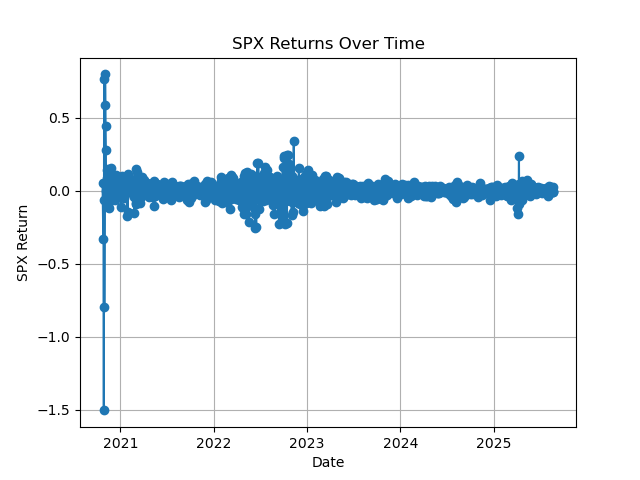
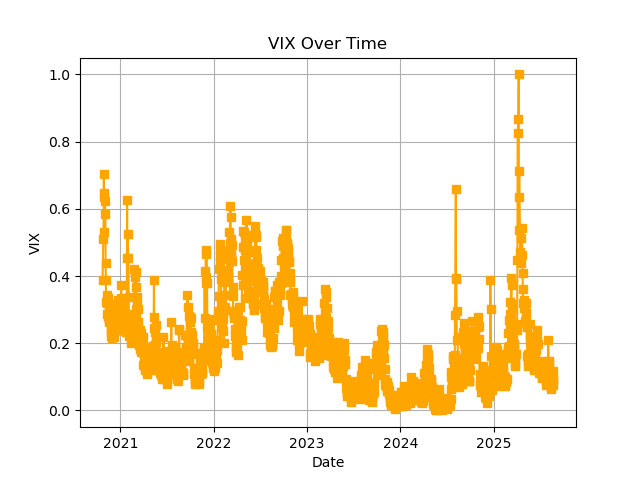
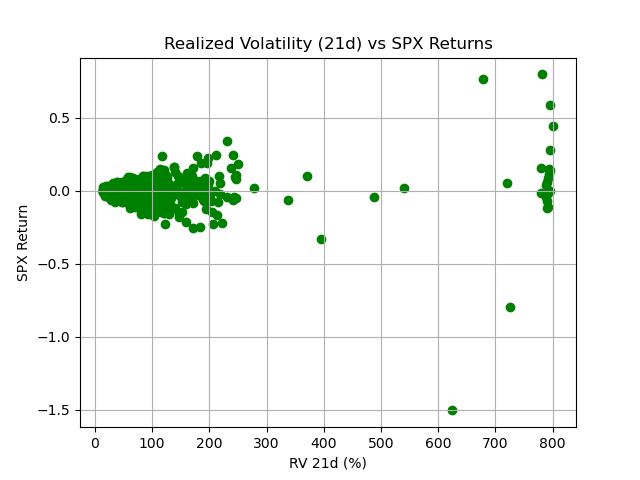

In [8]:
import requests
from IPython.display import display, HTML

# Example feature vector
example_features = [0.070698, 0.387695, 0.85, 0.09, 260.319, 6.9, 721.180880, -0.999462, 9.0]

# POST /predict
response = requests.post(
    'http://127.0.0.1:5000/predict',
    json={'features':example_features}
)
print(response.json())

# GET /predict/<input1>
response2 = requests.get('http://127.0.0.1:5000/predict/2.0')
print(response2.json())

# GET /predict/<input1>/<input2>
response3 = requests.get('http://127.0.0.1:5000/predict/1.0/3.0')
print(response3.json())

# GET /plot
response_plot = requests.get('http://127.0.0.1:5000/plot')
display(HTML(response_plot.text))

## 8. Optional Streamlit / Dash Dashboard

### Add dashboard in a separate file (`app_streamlit.py` or `app_dash.py`)

## 9. Handoff Best Practices

- Ensure README.md is complete and clear
- Provide `requirements.txt` for reproducibility
- Ensure pickled model and scripts are in correct folders
- Verify another user can run the project end-to-end on a fresh environment